# Training and evaluation

1. Caricamento dei dati di training, validazione e test preparati in precedenza
2. Definizione di una funzione per calcolare le metriche di valutazione (RMSE, MAE, R^2)
3. Addestramento e valutazione di un modello di baseline (Ridge Regression)
4. Addestramento e valutazione di modelli più complessi (RandomForestRegressor, XGBRegressor)
5. Confronto finale delle performance

In [61]:
RANDOM_STATE = 42

### Caricamento splittings

In [62]:
import pandas as pd
import os

X_train = pd.read_csv(os.getcwd()+'/processed_data/X_train.csv')
X_val = pd.read_csv(os.getcwd()+'/processed_data/X_val.csv')
X_test = pd.read_csv(os.getcwd()+'/processed_data/X_test.csv')

y_train = pd.read_csv(os.getcwd()+'/processed_data/y_train.csv').values.ravel()
y_val = pd.read_csv(os.getcwd()+'/processed_data/y_val.csv').values.ravel()
y_test = pd.read_csv(os.getcwd()+'/processed_data/y_test.csv').values.ravel()

In [63]:
print(f"Training set:   X_train -> {X_train.shape}, y_train -> {y_train.shape}")
print(f"Validation set: X_val   -> {X_val.shape}, y_val   -> {y_val.shape}")
print(f"Test set:       X_test  -> {X_test.shape}, y_test  -> {y_test.shape}")

Training set:   X_train -> (5983, 107), y_train -> (5983,)
Validation set: X_val   -> (1283, 107), y_val   -> (1283,)
Test set:       X_test  -> (1283, 107), y_test  -> (1283,)


### Funzione di Valutazione

Serve per mantenere il codice pulito e a valutare ogni modello in modo consistente.

In [64]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


def evaluate_model(y_true, y_pred, model_name=""):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    print(f"--- Results for {model_name} ---")
    print(f"RMSE:\t\t{rmse:.4f}")
    print(f"MAE:\t\t{mae:.4f}")
    print(f"R-squared:\t{r2:.4f}")
    print("-" * 30)

    return {'RMSE': rmse, 'MAE': mae, 'R2': r2}


Per ottimizzare gli iperparametri ho scelto l’RMSE come metrica principale di validazione. Ho fatto questa scelta perché l’RMSE penalizza di più gli errori grandi, spingendo così il modello a evitare previsioni molto lontane dai valori reali. Ho comunque considerato anche MAE e R^2 per avere una visione più completa delle prestazioni.

### Baseline: Ridge Regression (tuning and evaluation)

In [65]:
from sklearn.linear_model import Ridge
import numpy as np

# griglia degli iperparametri da utilizzare (dizionario)
param_grid_ridge = {
    'alpha': [0.01, 0.1, 1.0, 10.0, 100.0]
}

best_rmse = float('inf')
best_alpha = None
best_ridge_model = None

# grid search implementata manualmente
for alpha in param_grid_ridge['alpha']:
    model = Ridge(alpha=alpha, random_state=RANDOM_STATE)  # altri parametri di default
    model.fit(X_train, y_train)
    y_val_pred = model.predict(X_val)
    current_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))

    print(f"alpha: {alpha} -> RMSE: {current_rmse:.4f}")

    if current_rmse < best_rmse:
        best_rmse = current_rmse
        best_alpha = alpha
        best_ridge_model = model

print(f"best_alpha: {best_alpha}")
print(f"best_rmse: {best_rmse:.4f}")


alpha: 0.01 -> RMSE: 1.0846
alpha: 0.1 -> RMSE: 1.0844
alpha: 1.0 -> RMSE: 1.0836
alpha: 10.0 -> RMSE: 1.0829
alpha: 100.0 -> RMSE: 1.0849
best_alpha: 10.0
best_rmse: 1.0829


evaluation del best models sul test set, calcolando tutte le metriche:

In [66]:
y_test_pred_ridge = best_ridge_model.predict(X_test)
ridge_test_metrics = evaluate_model(y_test, y_test_pred_ridge, f"Ridge (alpha={best_alpha})")

--- Results for Ridge (alpha=10.0) ---
RMSE:		1.1785
MAE:		0.8150
R-squared:	0.1761
------------------------------


salviamo i risultati per il confronto finale

In [67]:
results = {}
results[f'Ridge (alpha={best_alpha})'] = ridge_test_metrics
results

{'Ridge (alpha=10.0)': {'RMSE': np.float64(1.1785198487367596),
  'MAE': 0.814963320265847,
  'R2': 0.17607789366164772}}

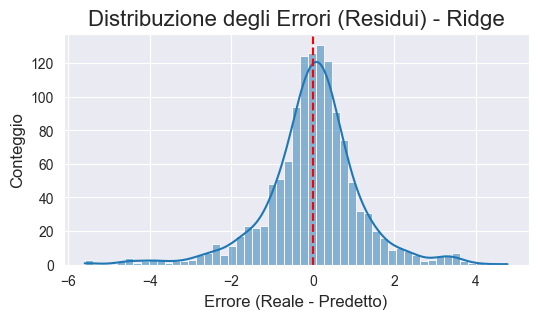

In [68]:
import matplotlib.pyplot as plt
import seaborn as sns

residui_ridge = y_test - y_test_pred_ridge

plt.figure(figsize=(6, 3))
sns.histplot(residui_ridge, kde=True)

# Aggiungiamo una linea di riferimento a x=0 (errore nullo)
plt.axvline(x=0, color='red', linestyle='--')

plt.title('Distribuzione degli Errori (Residui) - Ridge', fontsize=16)
plt.xlabel('Errore (Reale - Predetto)', fontsize=12)
plt.ylabel('Conteggio', fontsize=12)
plt.show()


osservazioni:
- distribuzione approssimativamente normale
- media molto vicina allo zero: il modello non tende nè a sovrastimare nè a sottostimare
- la maggioranza degli errori si concentra nel range [-2, 2], coerente con l'RMSE di 1.18

Analizziamo le feature più influenti per il modello

In [69]:
coefficients = best_ridge_model.coef_
feature_names = X_train.columns
coef_df = pd.DataFrame({'feature': feature_names, 'coefficient': coefficients})
coef_df['abs_coefficient'] = coef_df['coefficient'].abs()
coef_df = coef_df.sort_values('abs_coefficient', ascending=False)

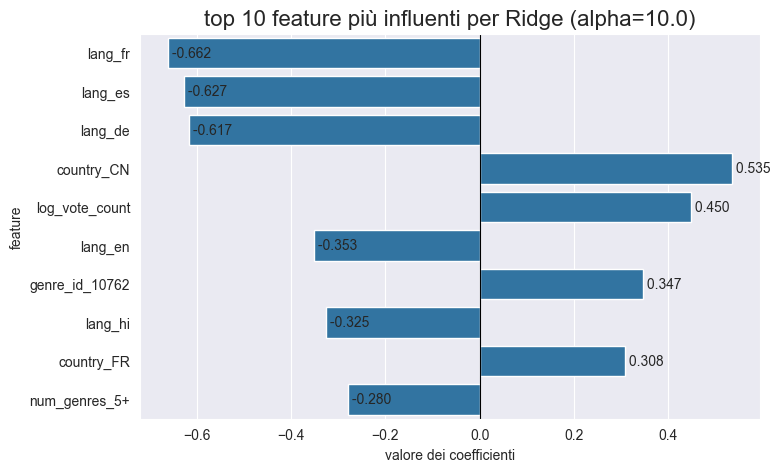

In [70]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 5))
sns.barplot(x='coefficient', y='feature', data=coef_df.head(10))
plt.title(f'top 10 feature più influenti per Ridge (alpha={best_alpha})', fontsize=16)
plt.xlabel('valore dei coefficienti')
plt.ylabel('feature')
plt.axvline(0, color='black', linewidth=0.8)

# per inserire il valore nella barra
for index, value in enumerate(coef_df.head(10)['coefficient']):
    plt.text(value, index, f' {value:.3f}', va='center')

plt.show()


osservazioni:
- Le tre feature più influenti in assoluto sono "lang_fr", "lang_es" e "lang_de". Questo risultato è in linea con l'analisi esplorativa, dove avevamo osservato che le serie in lingua francese, spagnola e tedesca avevano un voto medio più basso rispetto alle altre.
- il modello ha imparato ad associare un numero molto elevato di generi a una valutazione leggermente più bassa
- La feature più influente in senso positivo è country_CN, quindi le produzioni cinesi tendono ad avere un voto medio maggiore
- log_vote_count (+0.450) è il secondo predittore positivo più forte, confermando l'analisi preliminare e l'efficacia della trasformazione logaritmica
- genre_id_10762 (+0.347) ha un impatto positivo (genere kids)
- country_FR (+0.308) ha un coefficiente positivo, il che va in contrasto con l'analisi sulla lingua: evidentemente secondo il modello le co-produzioni che includono la Francia ma che non sono necessariamente in lingua francese tendono ad avere un voto maggiore

### RandomForestRegressor

Passiamo ora a un modello più potente, il RandomForestRegressor. Essendo un modello basato su alberi, può catturare relazioni non lineari che la RidgeRegression non riesce a modellare.

Per trovare la migliore combinazione di iperparametri, utilizzeremo GridSearchCV (di scikit-learn). Esso verrà addestrato usando il nostro training set e valutato su ogni combinazione usando il nostro validation set. Questo si ottiene passando uno "splitter" personalizzato (PredifinedSplit) a GridSearchCV.

In [71]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, PredefinedSplit

# per utilizzare i nostri split
X_train_val = pd.concat([X_train, X_val])
y_train_val = np.concatenate([y_train, y_val])
# array per dire quali indici inserire nel test (-1 per quelli da inserire nel training)
split_index = [-1] * len(X_train) + [0] * len(X_val)
ps = PredefinedSplit(test_fold=split_index)


param_grid_rf = {
    'n_estimators': [100, 150, 200],         # numero di alberi nell'ensemble
    'max_depth': [10, 20, 30, None],        # profondità massima che può avere un albero
    'min_samples_leaf': [2, 3, 4],         # campioni (osservazioni) minimi che devono trovarsi in un nodo "foglia"
                                        # SERVE PER BLOCCARE LA CREASCITA DELL'ALBERO
    'max_features': ['sqrt', 'log2']    # verranno considerate sqrt(n_features) feature o log2(n_features) feature
}

rf = RandomForestRegressor(random_state=RANDOM_STATE, n_jobs=-1) # utilizziamo tutti i processori

grid_search_rf = GridSearchCV(estimator=rf,
                              param_grid=param_grid_rf,
                              cv=ps,  # nostro split personalizzato
                              scoring='neg_root_mean_squared_error', # metrica di scoring
                              verbose=2,  # Mostra i progressi
                              n_jobs=-1) # Usa tutti i core della CPU

grid_search_rf.fit(X_train_val, y_train_val)
print("--- GridSearchCV completed ---")

Fitting 1 folds for each of 72 candidates, totalling 72 fits
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=2, n_estimators=100; total time=   0.5s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=3, n_estimators=100; total time=   0.5s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=4, n_estimators=100; total time=   0.7s
[CV] END max_depth=10, max_features=log2, min_samples_leaf=2, n_estimators=100; total time=   0.3s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=2, n_estimators=150; total time=   0.9s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=3, n_estimators=150; total time=   0.9s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=4, n_estimators=150; total time=   0.9s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=3, n_estimators=200; total time=   1.0s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=2, n_estimators=200; total time=   1.1s
[CV] END max_depth=10, max_features=log2, min_sa

In [72]:
print(f"Best params: {grid_search_rf.best_params_}")
best_validation_rmse_rf = -grid_search_rf.best_score_
print(f"Best RMSE: {best_validation_rmse_rf:.4f}")
best_rf_model = grid_search_rf.best_estimator_

Best params: {'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'n_estimators': 200}
Best RMSE: 1.0381


Ora che abbiamo trovato il modello ottimale, lo valutiamo sul test set e analizziamo l'importanza delle feature.

In [73]:
y_test_pred_rf = best_rf_model.predict(X_test)
rf_test_metrics = evaluate_model(y_test, y_test_pred_rf, "RandomForest (tuned)")
results['RandomForest'] = rf_test_metrics

--- Results for RandomForest (tuned) ---
RMSE:		1.1407
MAE:		0.7771
R-squared:	0.2281
------------------------------


Analizziamo l'importanza delle feature

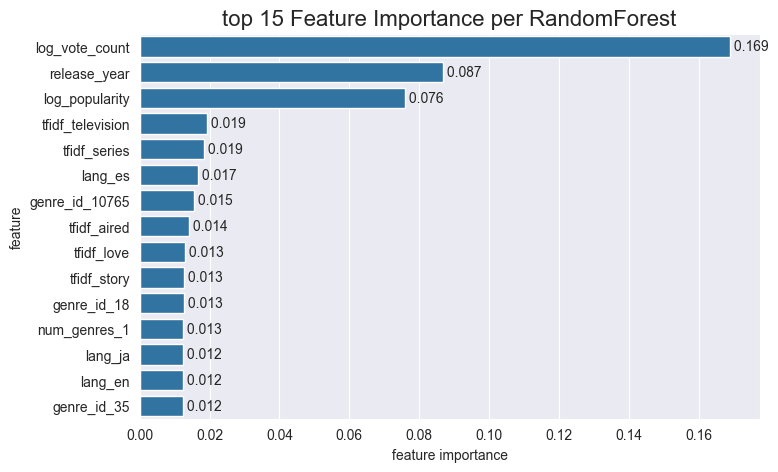

In [80]:
importances = best_rf_model.feature_importances_
feature_names = X_train.columns

importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
importance_df = importance_df.sort_values('importance', ascending=False)

plt.figure(figsize=(8,5))
sns.barplot(x='importance', y='feature', data=importance_df.head(15))
plt.title('top 15 Feature Importance per RandomForest', fontsize=16)
plt.xlabel('feature importance')
plt.ylabel('feature')

# per inserire il valore nella barra
for index, value in enumerate(importance_df.head(15)['importance']):
    plt.text(value, index, f' {value:.3f}', va='center')

plt.show()
